In [74]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%reload_ext autoreload
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"],12)
cov = ind["1996":"2000"].cov() #The covariance matrix

<AxesSubplot:xlabel='Volatility'>

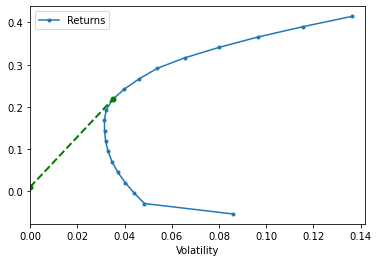

In [71]:
erk.plot_ef(20, er, cov, riskfree_rate=0.01, show_cml=True)

## Function Wrote

In [ ]:
def optimal_weights(n_points, er, cov):
    """
    --> generate a list of weights to run the optimizer on to minimize the vol
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs] #Pour juste avoir des points sur la frontière efficiente
    return weights

def plot_ef(n_points, er, cov, style=".-", show_cml=False, riskfree_rate=0):
    """
    Plots the N-asset efficient frontier
    """
   
    weights = optimal_weights(n_points, er ,cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style)
    if show_cml:
        ax.set_xlim(left = 0)
        rf = 0.1
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        #Add capital market line
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color="green", marker="o", linestyle="dashed", markersize = 5, linewidth= 2)
        return ax
    

def msr(risk_free_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio given 
    the riskfree rate and expected returns and a covariance matrix
    
    """
    n = er.shape[0] #determine the number of assets
    init_guess = np.repeat(1/n, n) #Initial weight vector is equally distributed
    bounds = ((0.0, 1),) * n #I don't want to be able to short, multiply a tuple make some copy of it
    
    
    weights_sum_to_1 = {
        "type":"eq",         #{constraints} eq = equalize to 0
        "fun": lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe_ratio(weights, risk_free_rate, er, cov):
        """
        Returns the negative of the sharpe ratio, given weights
        
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return  -(r-risk_free_rate) / vol
        
        
    results = minimize(neg_sharpe_ratio, init_guess,
                       args = (risk_free_rate, er, cov,), method="SLSQP", 
                       options= {"disp": False},
                       constraints=(weights_sum_to_1),
                       bounds = bounds
                       )
    return results.x

In [87]:
A =[22,24,21,27,34] 
B =[24,21,20,7,26]

x = pd.DataFrame({"A": A,"B":B}).pct_change()
x


,A,B
0,NaN,NaN
1,0.090909,-0.125000
2,-0.125000,-0.047619
3,0.285714,-0.650000
4,0.259259,2.714286
